<a href="https://colab.research.google.com/github/Pikarz/tirocinio_infostud/blob/main/OC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dati infostud attraverso il modello OC-SVM

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
### rende oc-svm più veloce computazionalmente
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Load data: funzione ```load_time_series```


La funzione ```load_time_series``` dato un path $p$, una lista di features $F$, un nome di file, che ne rappresenta il tipo, come ```http_request```, $T$, un numero di files massimi $n$ e due booleani $b_{convtime}, b_{intersect}$: restituisce un DataFrame $\mathbf{D}$ che contiene i dati dei primi $n$ files non vuoti delle colonne $F$, le cui righe hanno come indice il timestamp rispettivo. Il timestamp, se $b_{convtime}$ è ```True```, viene convertito in formato ```datetime```, altrimenti viene restituito il formato originale.

Se $b_{intersect}$ è ```True```, per ogni singolo file viene effettuata l'intersezione delle features in funzione del timestamp, altrimenti viene effettuata l'unione riempiendo di valori ```NaN``` nei punti in cui a un certo timestamp, per una certa feature, non è presente alcuna osservazione.

Ad esempio, supponendo di lanciare ```load_time_series``` con un unico file $f$ non vuoto e vogliamo estrarre le features $F = [\mathbf{value0}, \mathbf{value1}]$ con $b_{intersect}$ a ```True```.

Alla riga $14$ ```load_time_series``` osserverà le features $F$ di $f$, creando un DataFrame per ogni feature. Alla riga $17$ all'interno del ciclo ```for``` avremo quindi i due dataset:

$\mathbf{D_1} = \begin{pmatrix} \mathbf{timestamp} & \mathbf{value0} \\
\text{15-07-23_18:04:22} & 17 \\
\text{15-07-23_18:09:22} & 242
\end{pmatrix} $

$\mathbf{D_2} = \begin{pmatrix} \mathbf{timestamp} & \mathbf{value1} \\
\text{15-07-23_18:04:22} & 18 \\
\text{15-07-23_18:10:22} & 9
\end{pmatrix} $

La funzione effettua l'intersezione delle feature su $f$ in funzione al timestamp alla riga $22$. Il risultato è il seguente DataFrame:

$\mathbf{D} = \begin{pmatrix} \mathbf{timestamp} & \mathbf{value0} & \mathbf{value1}\\
\text{15-07-23_18:04:22} & 17 & 18\\
\end{pmatrix} $

Poiché abbiamo lanciato ```load_time_series``` solo sul singolo file $f$, essa restituirà $\mathbf{D}$.

Se invece avessimo settato $b_{intersect}$ a ```False```, avremmo ottenuto il seguente DataFrame:
$\mathbf{D} = \begin{pmatrix} \mathbf{timestamp} & \mathbf{value0} & \mathbf{value1}\\
\text{15-07-23_18:04:22} & 17 & 18\\
\text{15-07-23_18:09:22} & 242 & NaN\\
\text{15-07-23_18:10:22} & NaN & 9
\end{pmatrix} $

In [ ]:
# versione aggiornata e correttamente funzionante.
# AGGIORNAMENTO: esiste una versione più recente che si trova nel file 'updated_load_time_series' che prende in input anche un intervallo di date, tuttavia vorrei tenerle distinte

import os
import pandas as pd
import glob

def load_time_series(path, features, file_type, max_files=1, convert_to_timestamp=False, intersection=True):
    json_dir = os.path.join(path, file_type + '*.json')
    df_all_files = []
    file_counter = 0

    for file in sorted(glob.glob(json_dir)):
        if file_counter >= max_files:
            break
        print("Reading file " + file + "\n")
        df = pd.read_json(file)
        first_feature, remaining_features = features[0], features[1:]
        try:
            df_single_file = pd.DataFrame(df['data']['result'][first_feature]['values'])
            df_single_file.columns = ['timestamp', 'value' + str(first_feature)]
            df_single_file.set_index('timestamp', inplace=True)
            df_single_file['value' + str(first_feature)] = df_single_file['value' + str(first_feature)].astype(float)

            for i in remaining_features:
                df_single_feature = pd.DataFrame(df['data']['result'][i]['values'])
                df_single_feature.columns = ['timestamp', 'value' + str(i)]
                df_single_feature.set_index('timestamp', inplace=True)

                if intersection:
                    df_single_file = df_single_file.join(df_single_feature, how='inner')
                else:
                    df_single_file = pd.concat([df_single_file, df_single_feature], axis=1)
                df_single_file['value' + str(i)] = df_single_file['value' + str(i)].astype(float)

            df_all_files.append(df_single_file)
            file_counter += 1
        except IndexError:
            print("skipped\n")
            continue

    df_all_files = pd.concat(df_all_files)

    if convert_to_timestamp:
        # You may choose to skip this step if the timestamps are already in datetime format.
        df_all_files.index = pd.to_datetime(df_all_files.index, unit='s')

    return df_all_files

# Training e plotting di diversi modelli OC-SVM: funzioni ```train_multiple_ocsvm``` e ```plot_decision_boundary```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.decomposition import PCA

def plot_decision_boundary(ocsvm, train_features, hyperparams):
  # Define the meshgrid for plotting decision function
  x_min, x_max = train_features[:, 0].min() - 5, train_features[:, 0].max() + 5
  y_min, y_max = train_features[:, 1].min() - 0.1, train_features[:, 1].max() + 0.1
  x_ = np.linspace(x_min, x_max, 500)
  y_ = np.linspace(y_min, y_max, 500)
  xx, yy = np.meshgrid(x_, y_)

  # Evaluate the decision function on the meshgrid
  z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
  z = z.reshape(xx.shape)

  # Plot the decision function and the data
  plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
  a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
  b = plt.scatter(train_features[ocsvm.predict(train_features) == 1, 0], train_features[ocsvm.predict(train_features) == 1, 1], c='white', edgecolors='k')
  c = plt.scatter(train_features[ocsvm.predict(train_features) == -1, 0], train_features[ocsvm.predict(train_features) == -1, 1], c='gold', edgecolors='r')

  if len(a.levels) == 0 or (len(a.levels) == 1 and a.levels[0] == 0):
    plt.legend([b, c], ['regular observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))
  else:
    plt.legend([a.collections[0], b, c], ['learned frontier', 'regular observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))

  plt.axis('tight')
  plt.title('Decision Boundary: ' + hyperparams)
  plt.show()

def train_multiple_ocsvm(train_data, params):
    train_features = train_data.values

    for kernel in params['kernel']:
        for nu in params['nu']:
            hyperparams = "nu: " + str(nu) + ", kernel: " + kernel
            print(hyperparams)

            ocsvm = OneClassSVM(nu=nu, kernel=kernel)
            ocsvm.fit(train_features)

            plot_decision_boundary(ocsvm, train_features, hyperparams)


def train_multiple_ocsvm_with_pca(train_data, params, n_components=2):
  train_features = train_data.values

  # Apply PCA for dimensionality reduction
  pca = PCA(n_components=n_components)
  train_features_reduced = pca.fit_transform(train_features)

  for kernel in params['kernel']:
    for nu in params['nu']:
      hyperparams = "nu: " + str(nu) + ", kernel: " + kernel
      print(hyperparams)

      ocsvm = OneClassSVM(nu=nu, kernel=kernel)
      ocsvm.fit(train_features_reduced)

      plot_decision_boundary(ocsvm, train_features_reduced, hyperparams)

# [old] Load data v1
Force merge between features (does not work)

In [ ]:
import pandas as pd
import glob

file_path = glob.glob("./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/*.json")
dataframe = []

for file in file_path:
  df = pd.read_json(file)
  try:
    dataframe.append(df['data']['result'][0]['values'])
  except IndexError: continue


df = pd.DataFrame.from_records(dataframe)

KeyboardInterrupt: ignored

Purtroppo i vari segnali hanno un numero di valori diverso tra di loro, seppur i timestamp di partenza e fine siano gli stessi, per cui non posso plottarli tutti insieme nativamente. I seguenti blocchi di codice mostrano l'errore e il rispettivo merge.

In [ ]:
import pandas as pd

df = pd.read_json('./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json')


In [ ]:
df_base = pd.DataFrame.from_records(df['data']['result'])

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame(df_base['values'][0], columns=['timestamp', 'value_0'])
df.set_index('timestamp', inplace=True)
df['value_0'] = df['value_0'].astype(float)
for i in range(1,6):
  val_name = 'value_'+str(i)
  df[val_name] = list(zip(*df_base['values'][i]))[-1] # extract only the value of the signal
  df[val_name] = df[val_name].astype(float)
  print("added column")
df.plot()
plt.show()

In [ ]:
df1 = pd.DataFrame(df_base['values'][0], columns=['timestamp', 'value_0'])
df1.set_index('timestamp', inplace=True)
df1['value_0'] = df1['value_0'].astype(float)
print(df1.shape)
df1.plot()
df2 = pd.DataFrame(df_base['values'][1], columns=['timestamp', 'value_1'])
df2.set_index('timestamp', inplace=True)
df2['value_1'] = df2['value_1'].astype(float)
print(df2.shape)
df2.plot()
merged_df = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
print(merged_df.shape) # it has more rows than df1
merged_df['value_0'] = merged_df['value_0'].astype(float)
merged_df['value_0'] = (merged_df['value_0'] - merged_df['value_0'].mean()) / merged_df['value_0'].std()+1e-5
merged_df['value_1'] = merged_df['value_1'].astype(float)
merged_df['value_1'] = (merged_df['value_1'] - merged_df['value_1'].mean()) / merged_df['value_1'].std()+1e-5
print(merged_df)
merged_df.plot()

# [old] Load data v2
Load only one feature across multiple files

In [ ]:
import pandas as pd
import glob

def load_json(path, feature, filename, columns, max_files):
  json_dir = path+filename+'*.json'
  df_combined = pd.DataFrame([])
  file_counter=0
  for file in sorted(glob.glob(json_dir)):
    if file_counter >= max_files: break
    df = pd.read_json(file)
    #print(df['data']['result'][0][0])
    try:
      df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)
      file_counter += 1
      print(file)
    except IndexError: continue
  df_combined.columns = columns
  df_combined = df_combined.set_index('timestamp')
  #df_combined['timestamp'] = pd.to_datetime(df_combined['timestamp'], unit='s')
  df_combined['value'] = df_combined['value'].astype(float)
  return df_combined

<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json


<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-03-30T00-00-00.json


<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-04-29T00-00-00.json


<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-05-29T00-00-00.json


<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-06-28T00-00-00.json


<ipython-input-8-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-07-28T00-00-00.json


<Axes: xlabel='timestamp'>

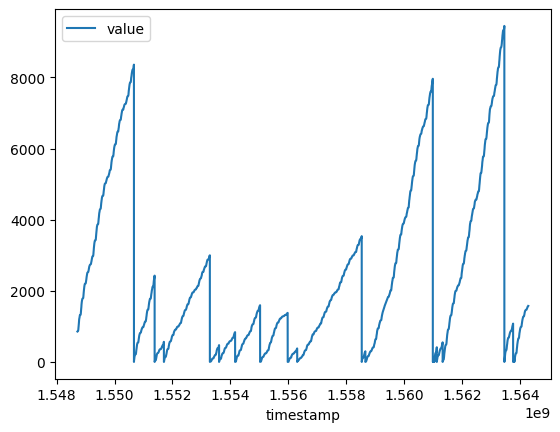

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
filename = 'compat_http_responses_'

df = load_json(path=path, feature=0, filename=filename, columns = ['timestamp', 'value'], max_files=5)
df.plot()

#OC-SVM 1
Tentativo 1 (v2) - small dataset (20k punti) su singola feature

Ho testato una piccola parte del dataset con OC-SVM con pessimi risultati; al variare degli iper-parametri, il modello classifica la maggior parte dei dati o come outliers o come inliers

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-01-29T00-00-00.json

skipped

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json



<Axes: xlabel='timestamp'>

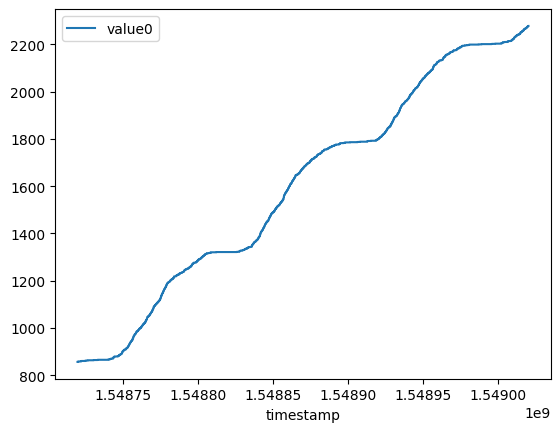

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
filename = 'compat_http_responses_'

n = 20000
df_1 = load_time_series(path=path, features=[0], file_type=filename, max_files=1)
df_1 = df_1.head(n)
df_1.plot()

**Standardize the data**

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#df = df.reset_index(drop=False)
scaler = MinMaxScaler()
df_1 = pd.DataFrame(scaler.fit_transform(df_1), index=df_1.index, columns=df_1.columns)
df_1 = df_1.reset_index()

**Fitting con diversi iperparametri**

Precedentemente facevo una grid-search simulando un ambiente supervised con label casuali. Ora attraverso ```train_multiple_ocsvm``` faccio il training su diversi iperparametri e plotto il decision boundary

nu: 0.001, kernel: linear


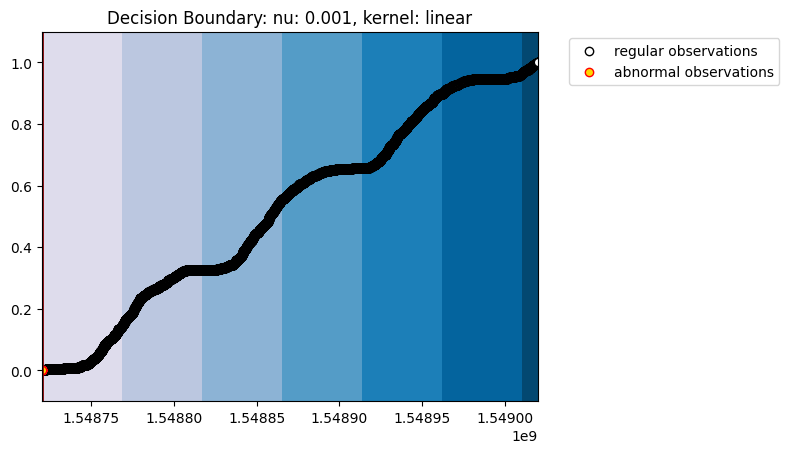

nu: 0.03, kernel: linear


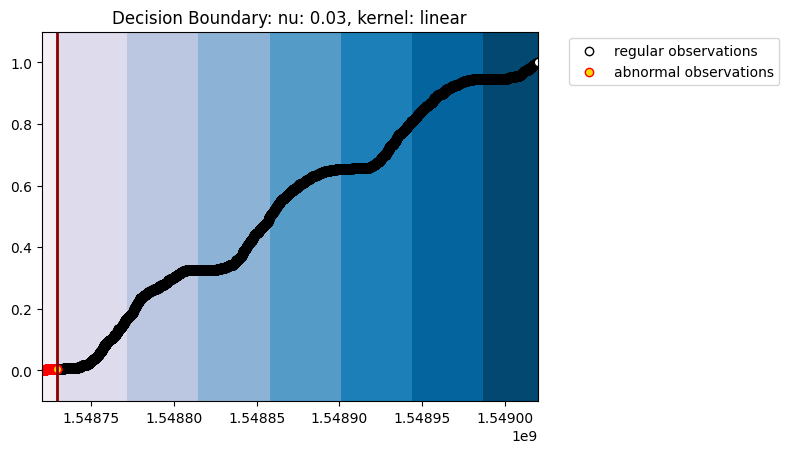

nu: 0.1, kernel: linear


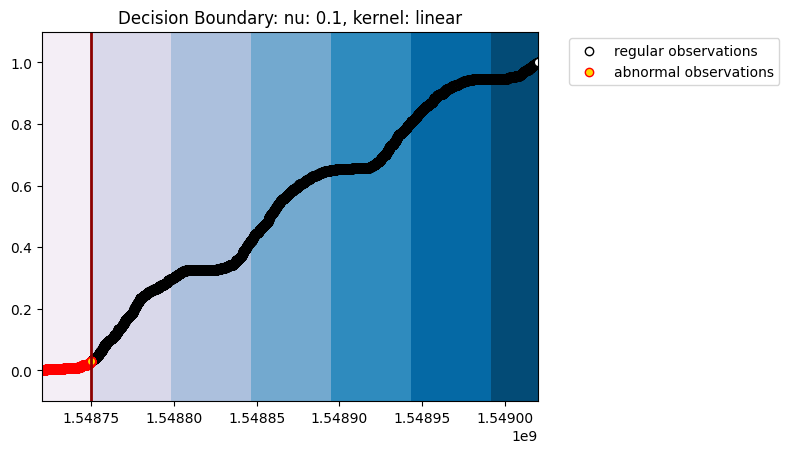

nu: 0.3, kernel: linear


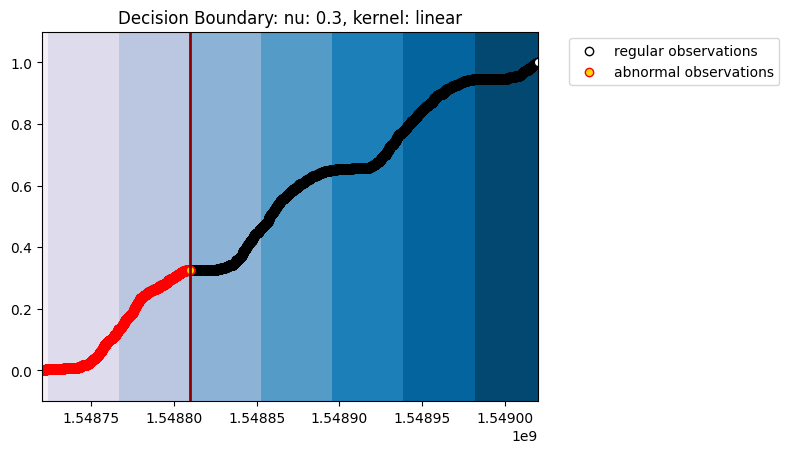

nu: 0.5, kernel: linear


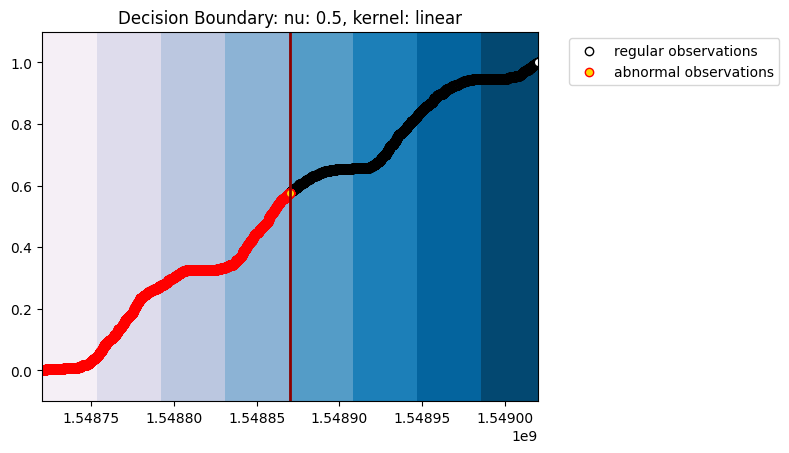

nu: 0.9, kernel: linear


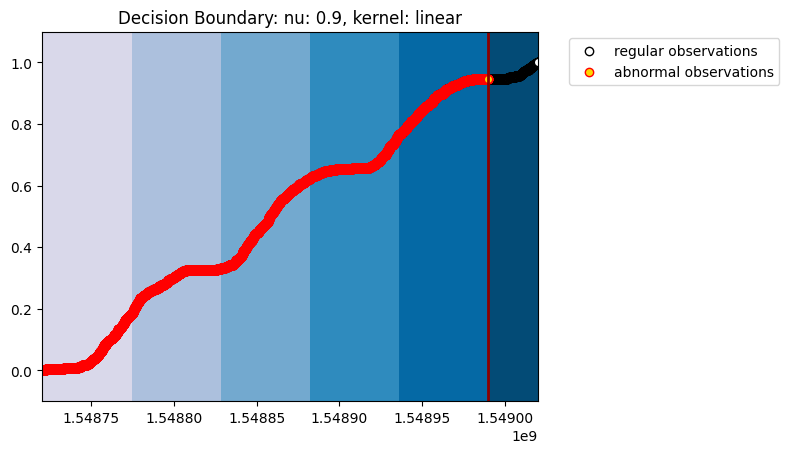

nu: 0.99, kernel: linear


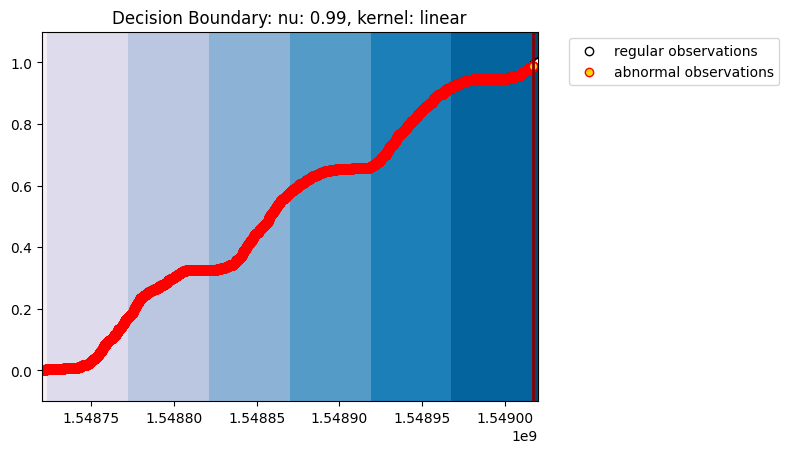

nu: 0.001, kernel: poly


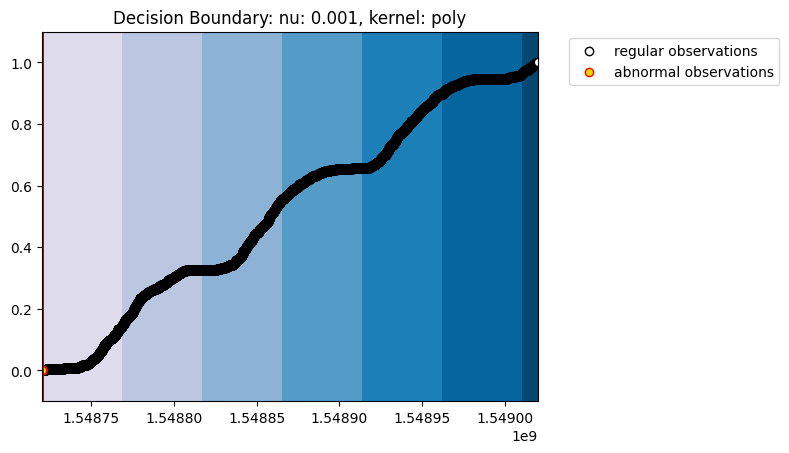

nu: 0.03, kernel: poly


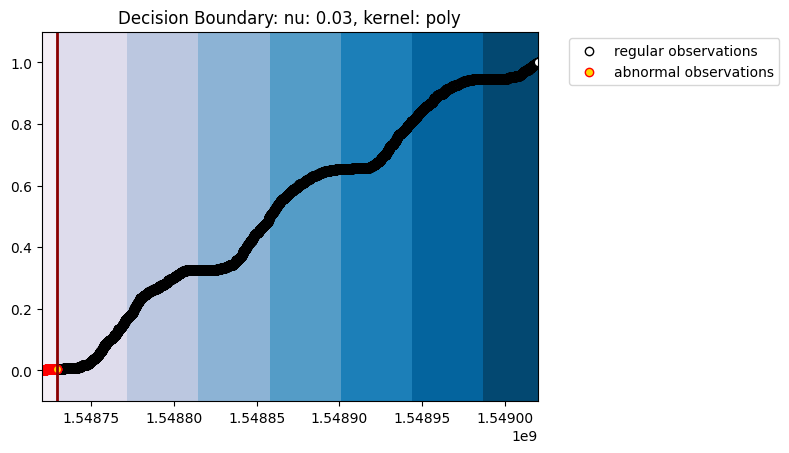

nu: 0.1, kernel: poly


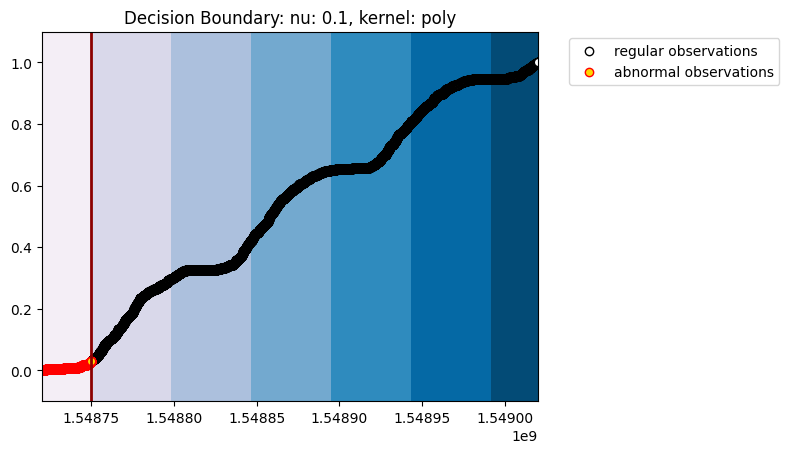

nu: 0.3, kernel: poly


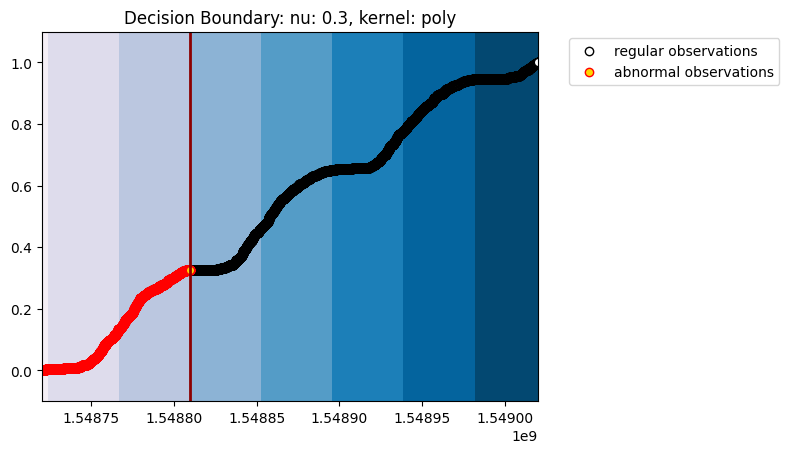

nu: 0.5, kernel: poly


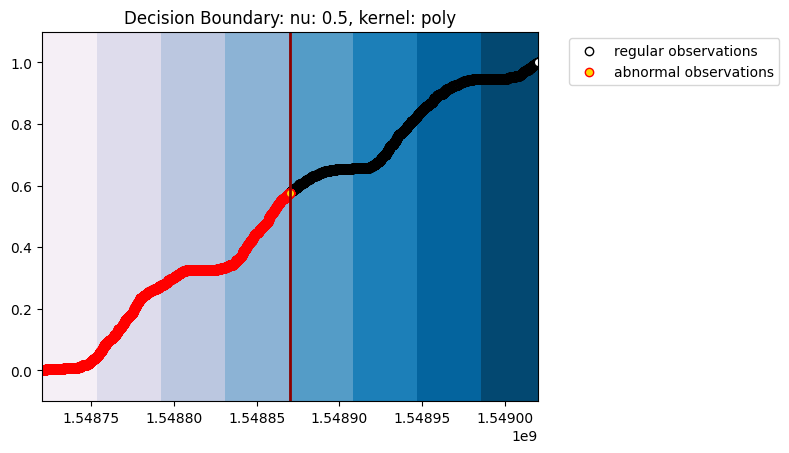

nu: 0.9, kernel: poly


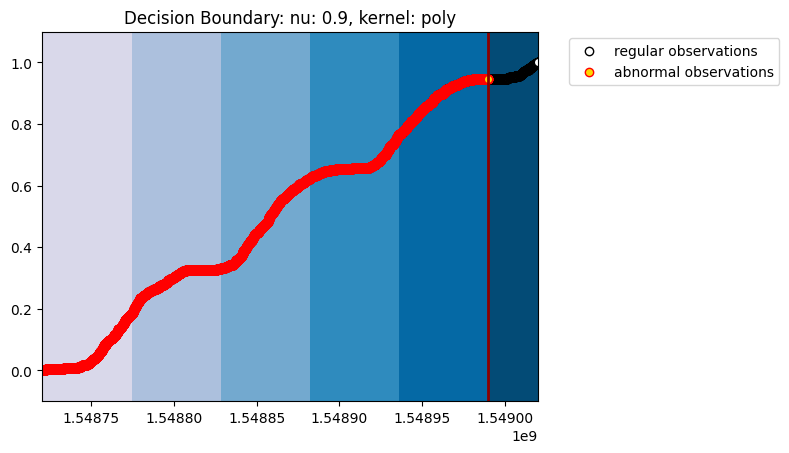

nu: 0.99, kernel: poly


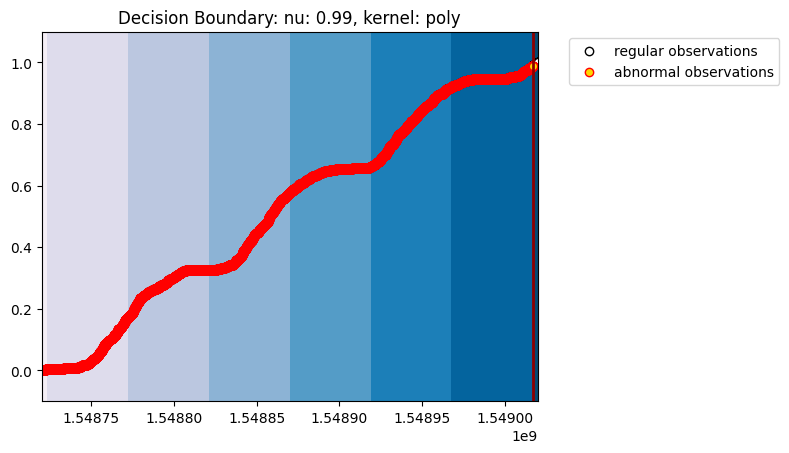

nu: 0.001, kernel: rbf


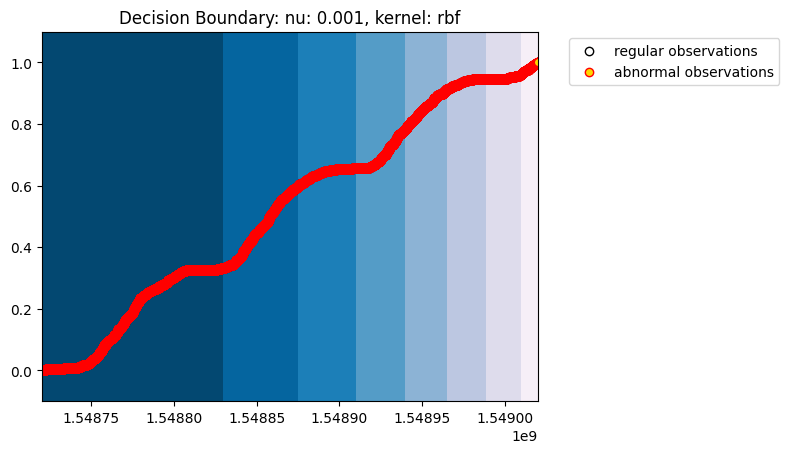

nu: 0.03, kernel: rbf


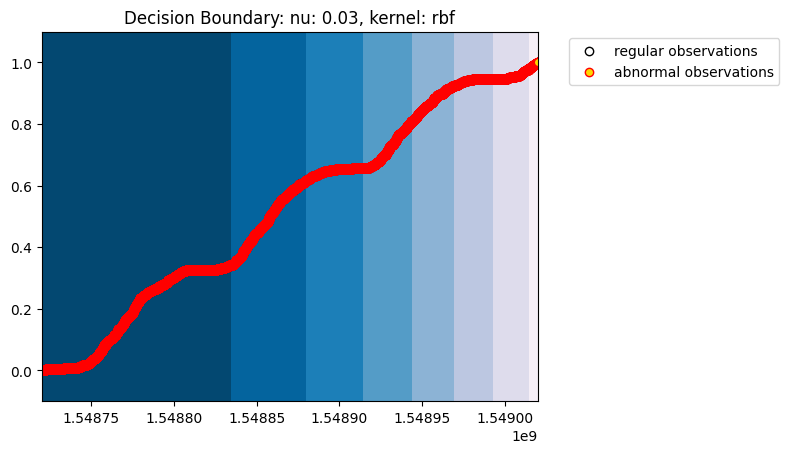

nu: 0.1, kernel: rbf


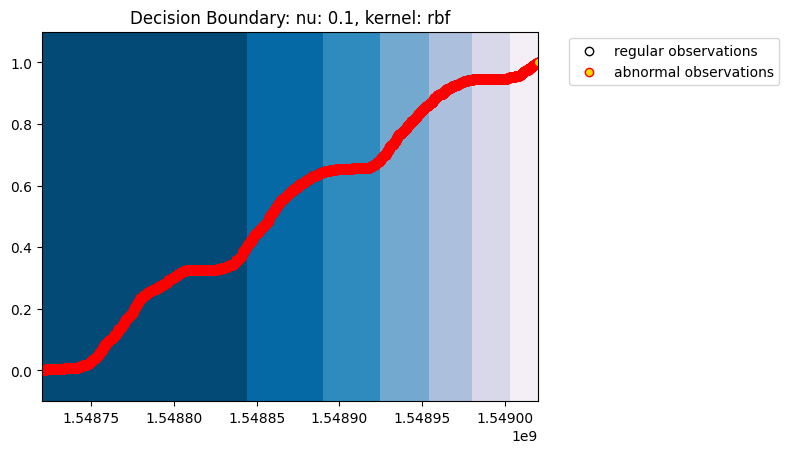

nu: 0.3, kernel: rbf


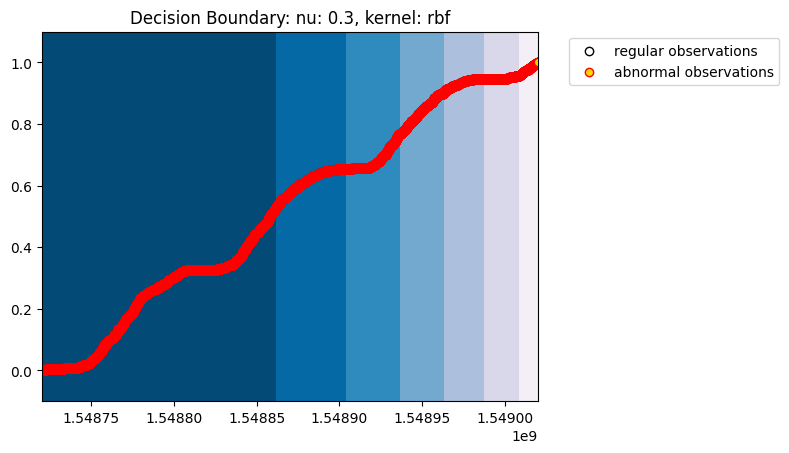

nu: 0.5, kernel: rbf


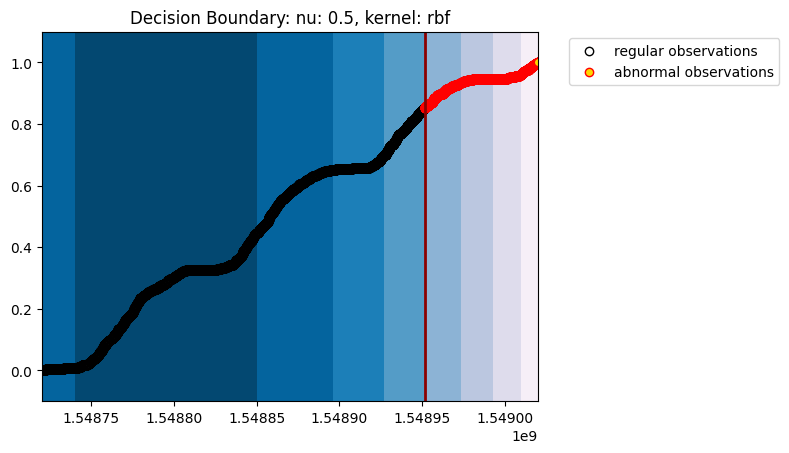

nu: 0.9, kernel: rbf


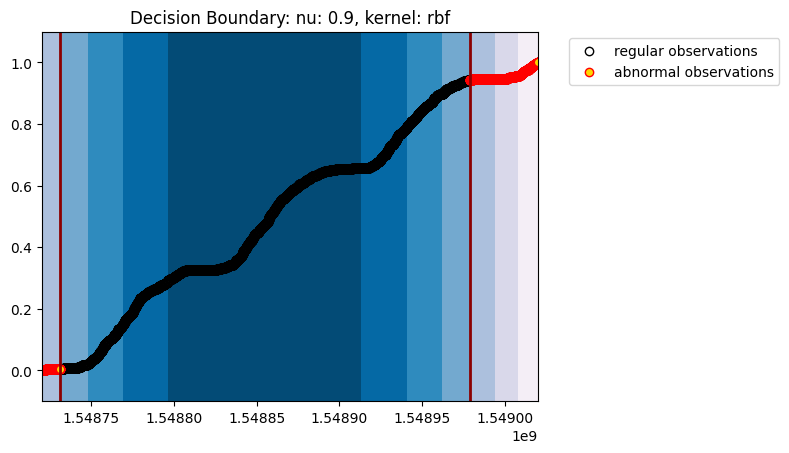

nu: 0.99, kernel: rbf


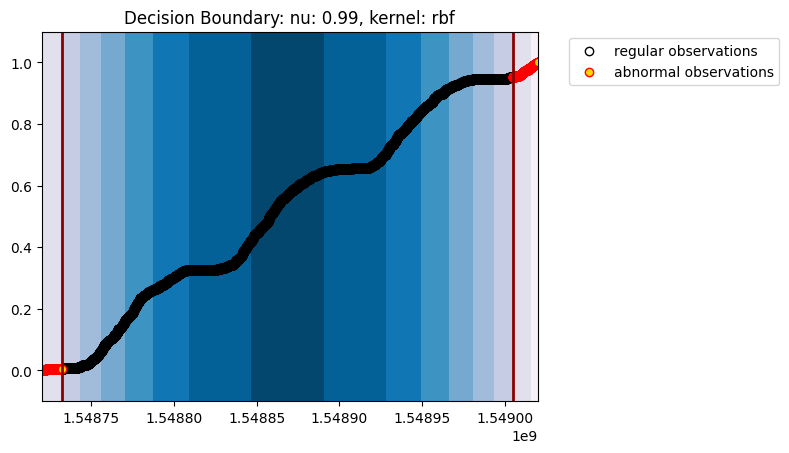

nu: 0.001, kernel: sigmoid


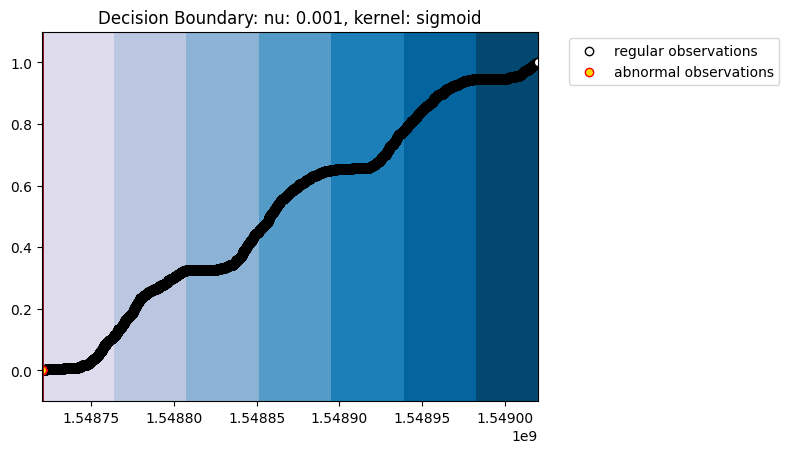

nu: 0.03, kernel: sigmoid


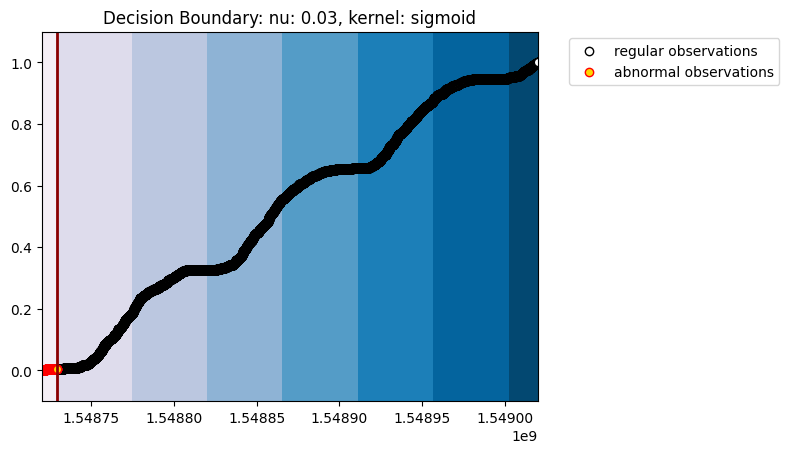

nu: 0.1, kernel: sigmoid


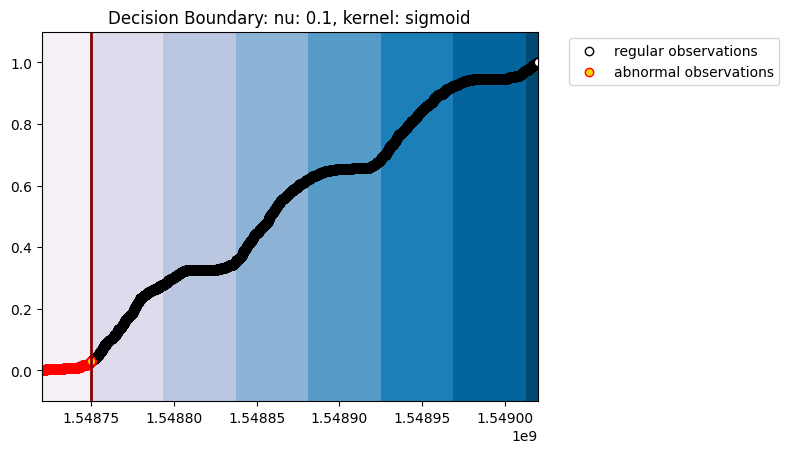

nu: 0.3, kernel: sigmoid


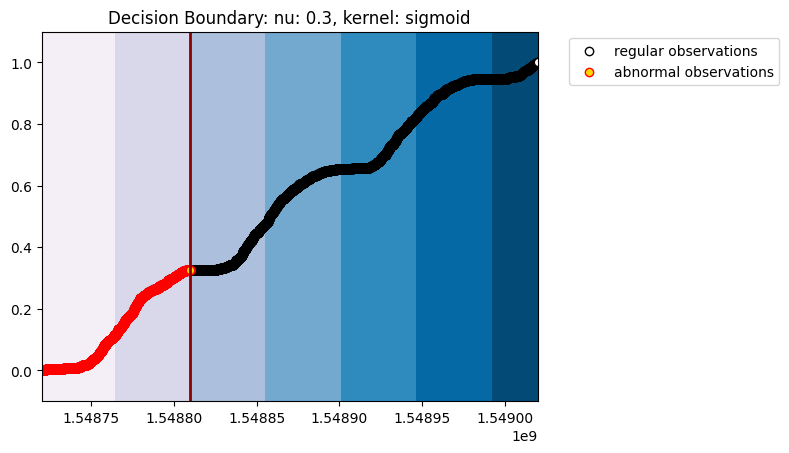

nu: 0.5, kernel: sigmoid


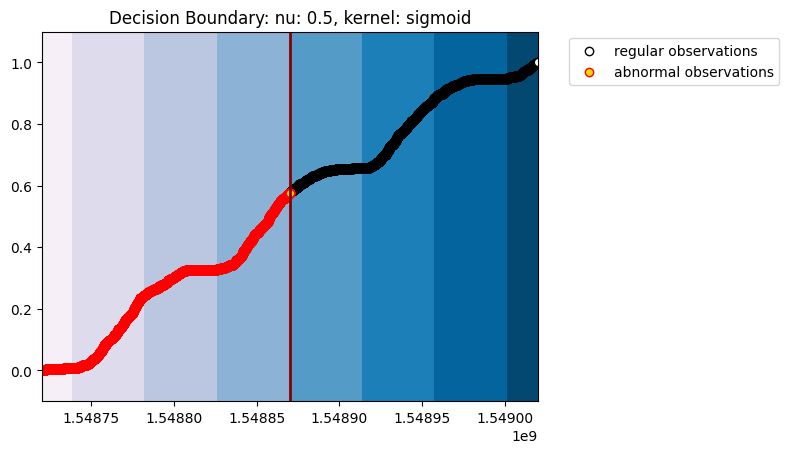

nu: 0.9, kernel: sigmoid


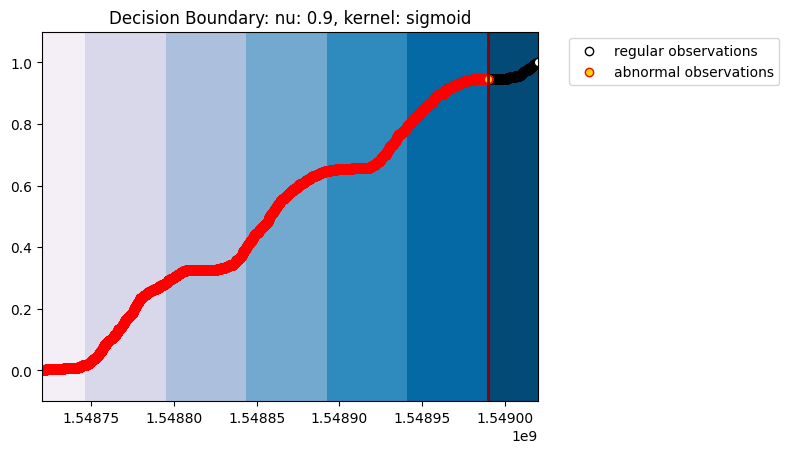

nu: 0.99, kernel: sigmoid


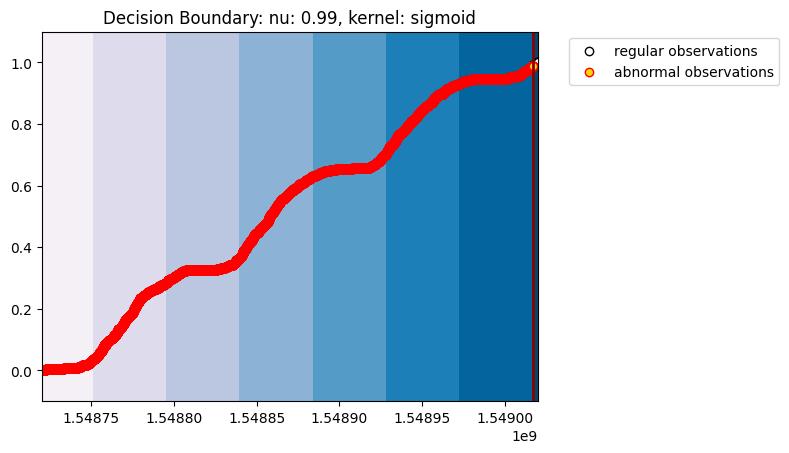

In [ ]:
params = {'nu': [0.001, 0.03, 0.1, 0.3, 0.5, 0.9, 0.99],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} # precomputed is not present because it needs a square matrix

train_multiple_ocsvm(df_1, params)

**Conclusioni 16/07/23:**

Su un dataset piccolo OC-SVM non sembra modellare soluzioni molto valide. Valori vicino allo zero sono solitamente segnalati come anomalie, mentre valori più alti sono considerati per lo più delle volte come valori consoni.

#OC-SVM 2
Tentativo 2 - $\approx$700k osservazioni

Seguo lo stesso procedimento di prima ma suddivido il dataset originale in train/test set, caricando più file all'unisono

In [ ]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

<ipython-input-4-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json


<ipython-input-4-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-03-30T00-00-00.json


<ipython-input-4-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-04-29T00-00-00.json


<ipython-input-4-682ebea43918>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df['data']['result'][feature]['values'], ignore_index=True)


./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-05-29T00-00-00.json


<Axes: xlabel='timestamp'>

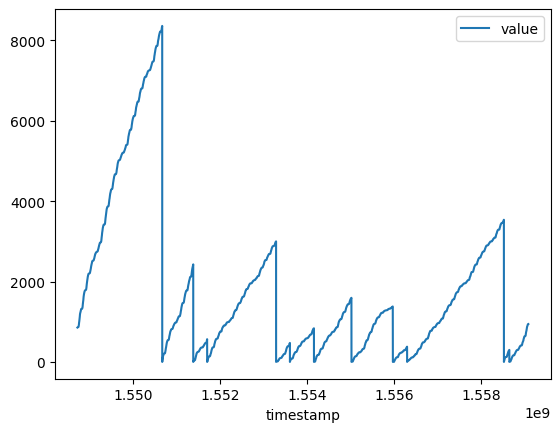

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
filename = 'compat_http_responses_'

df = load_json(path=path, feature=0, filename=filename, columns = ['timestamp', 'value'], max_files=3)
df.plot()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_sample = df
df_sample = df_sample.reset_index(drop=False)
X = df_sample.values
X = MinMaxScaler().fit(X).transform(X)

In [ ]:
X.shape

(689776, 2)

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

# Shuffle the dataset
random_state = 42  # Set a random state for reproducibility
np.random.seed(random_state)
np.random.shuffle(X)

# Split the dataset into training and testing sets
train_ratio = 0.8  # Proportion of data for training
X_train, X_test = train_test_split(X, train_size=train_ratio, random_state=random_state)

# Create and train the OC-SVM model
ocsvm = OneClassSVM(kernel='linear', nu=0.03)
ocsvm.fit(X_train)

# Evaluate the model
train_preds = ocsvm.predict(X_train)
test_preds = ocsvm.predict(X_test)

In [ ]:
# filter outlier index
outlier_index = np.where(test_preds == -1) # filter outlier values
outlier_values = df_sample.iloc[outlier_index]
outlier_values

,timestamp,value
61,1.548721e+09,858.0
84,1.548721e+09,858.0
85,1.548721e+09,858.0
149,1.548722e+09,859.0
201,1.548723e+09,860.0
...,...,...
137901,1.550796e+09,540.0
137902,1.550796e+09,540.0
137903,1.550796e+09,540.0
137907,1.550796e+09,540.0


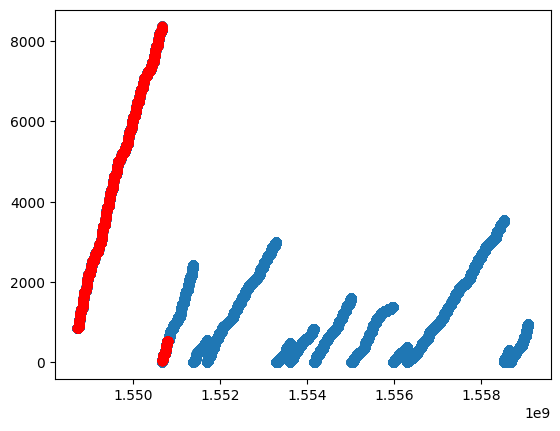

In [ ]:
import matplotlib.pyplot as plt
# visualize outputs
plt.scatter(df_sample['timestamp'], df_sample['value'])
plt.scatter(outlier_values['timestamp'], outlier_values['value'], c = "r")

**Conclusioni 01/07/23:**

Quest'oggi ho effettuato il training del dataset contenente osservazioni della prima feature sui primi 3 files non vuoti. Il dataset è composto da circa 689k osservazioni.

Gli iperparametri sono stati scelti in modo quasi arbitrario: kernel='linear', nu=0.03.

Ho effettuato uno split 80/20 sul dataset e ho effettuato il training che è durato circa 20 minuti.

Il modello, seppur non porti una soluzione molto adatta al problema, ha comunque dato un risultato interessante: sembra che esso abbia individuato i punti in cui il contatore, prima di essere resettato, ha raggiunto i valori più elevati su tutto il dataset.

#OC-SVM 3
Tentativo 3 - tutto il dataset compat_http_request (feature 0)

In [ ]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 22.3 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-01-29T00-00-00.json

skipped

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-03-30T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-04-29T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-05-29T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-06-28T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-07-28T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-08-27T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo 

<Axes: xlabel='timestamp'>

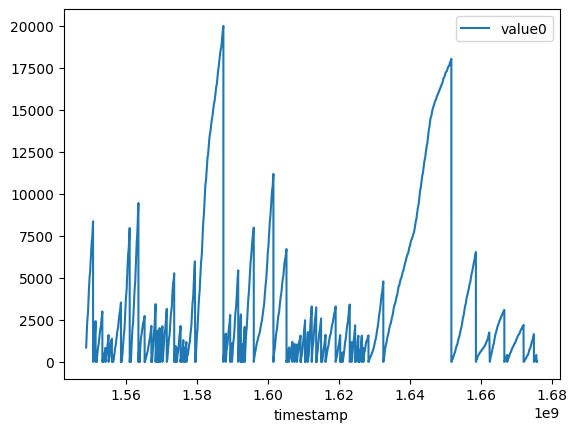

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
filename = 'compat_http_responses_'


#def load_time_series(path, features, file_type, max_files=1, convert_to_timestamp=False, intersection=True):

df = load_time_series(path=path, features=[0], file_type=filename, max_files=100)
df.plot()

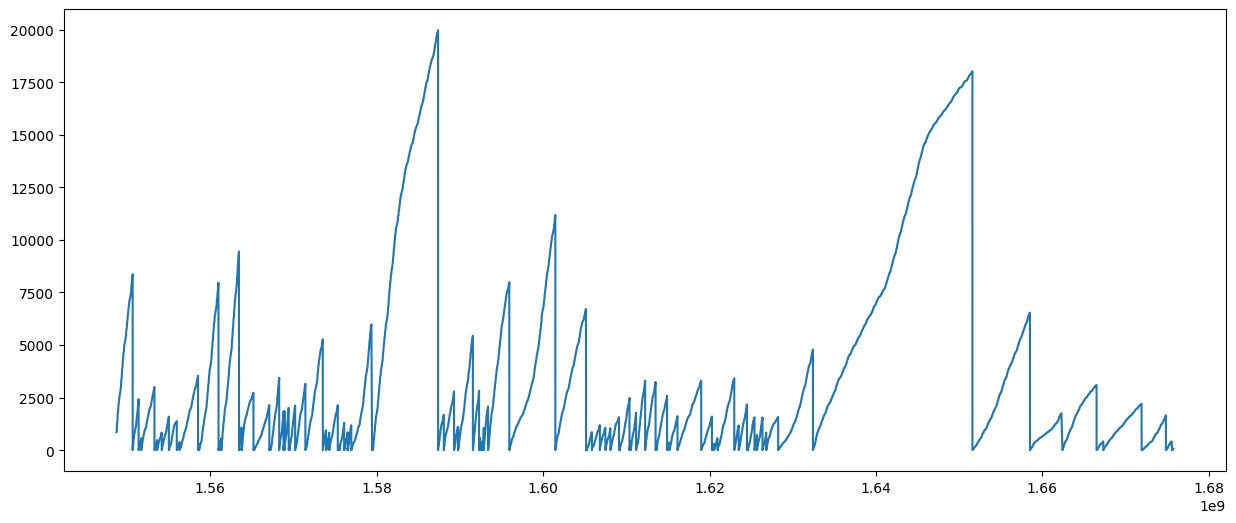

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df)
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_sample = df
df_sample = df_sample.reset_index(drop=False)
X = df_sample.values
X = MinMaxScaler().fit(X).transform(X)

In [ ]:
X.shape

(8293980, 2)

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

# Shuffle the dataset
random_state = 42  # Set a random state for reproducibility
np.random.seed(random_state)
np.random.shuffle(X)

# Split the dataset into training and testing sets
train_ratio = 0.8  # Proportion of data for training
X_train, X_test = train_test_split(X, train_size=train_ratio, random_state=random_state)

# Create and train the OC-SVM model
ocsvm = OneClassSVM(kernel='linear', nu=0.03)
ocsvm.fit(X_train)

# Evaluate the model
train_preds = ocsvm.predict(X_train)
test_preds = ocsvm.predict(X_test)

In [ ]:
# filter outlier index
outlier_index = np.where(test_preds == -1) # filter outlier values
outlier_values = df_sample.iloc[outlier_index]
outlier_values

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
# visualize outputs
plt.scatter(df_sample['timestamp'], df_sample['value'])
plt.scatter(outlier_values['timestamp'], outlier_values['value'], c = "r")

**Conclusioni**

Dopo circa 12 ore di training ho interrotto la computazione

#OC-SVM 4
Tentativo 4 - circa 36k osservazione su tutte e 6 le feature di compat_http_request. 15/07/23

Oss: questo tentativo si è servito della funzione ```load_time_series``` che aveva qualche problema quando ```intersection=False```

In [ ]:
from sklearn.preprocessing import MinMaxScaler

path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
file_type = 'compat_http_responses_'
n=30000
#df_4 = load_time_series(path=path, features=[x for x in range(6)], file_type=file_type, max_files=2, intersection=False)
df_4 = load_time_series(path=path, features=[3,4,5], file_type=file_type, max_files=2, intersection=False)

scaler = MinMaxScaler()
df_4_normalized = pd.DataFrame(scaler.fit_transform(df_4), index=df_4.index, columns=df_4.columns)
df_4_slice = df_4_normalized.iloc[n*5:n*6, :] # I chose this specific slice because for most of the dataset value5 is not there. This slice has observations for all the different values.

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-01-29T00-00-00.json

skipped

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-02-28T00-00-00.json

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2019-03-30T00-00-00.json



<Axes: xlabel='timestamp'>

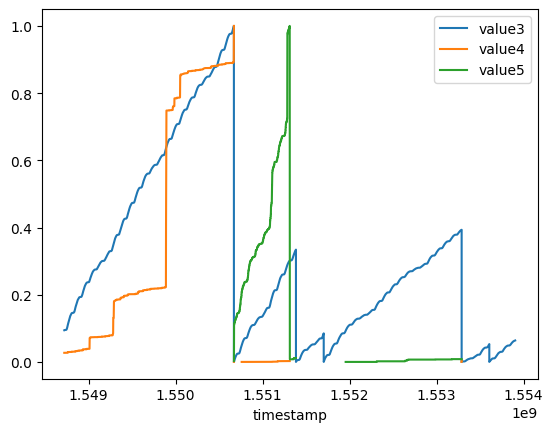

In [ ]:
df_4_normalized.plot() #grafico anomalo

<Axes: xlabel='timestamp'>

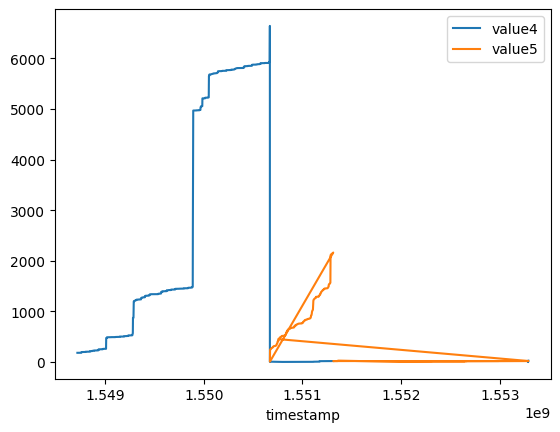

In [ ]:
df_4.plot() #grafico anomalo

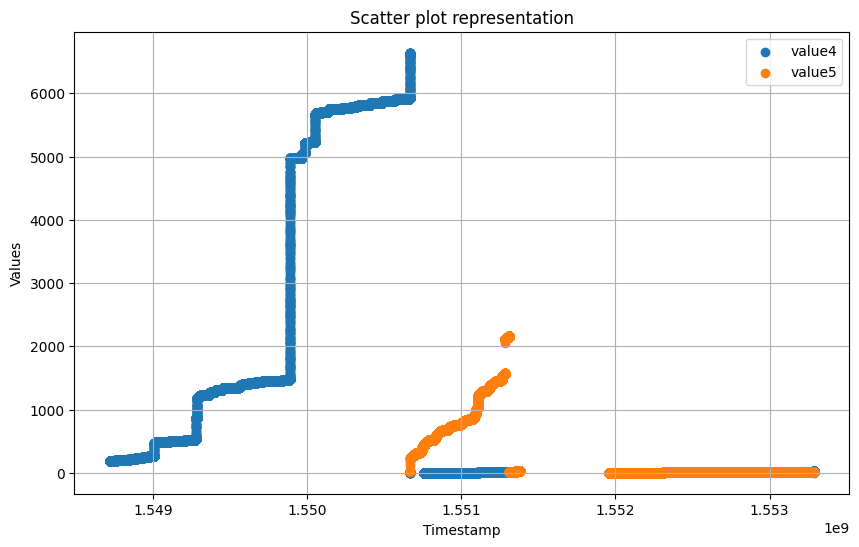

In [ ]:
#grafico anomalo scatter

import matplotlib.pyplot as plt

# Create a scatter plot for each feature
plt.figure(figsize=(10, 6))  # Set the figure size as desired

for feature in df_4.columns:
    plt.scatter(df_4.index, df_4[feature], label=feature)

plt.xlabel('Timestamp')  # Set the x-axis label as appropriate
plt.ylabel('Values')  # Set the y-axis label as appropriate
plt.title('Scatter plot representation')  # Set the plot title
plt.legend()  # Show the legend with feature names
plt.grid(True)  # Add gridlines to the plot
plt.show()  # Show the scatter plot

<Axes: xlabel='timestamp'>

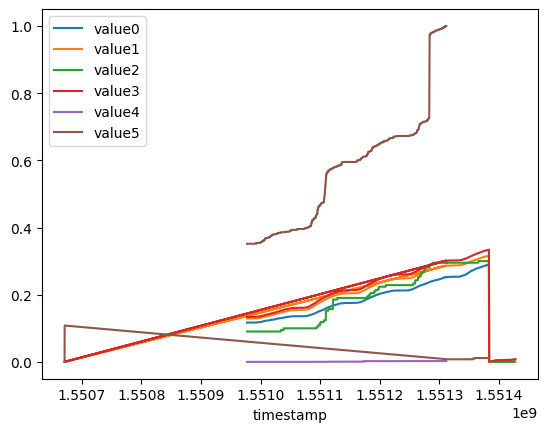

In [ ]:
df_4_slice.plot() # il plot è di un dataset estratto dalla funzione load_time_series che aveva qualche problema

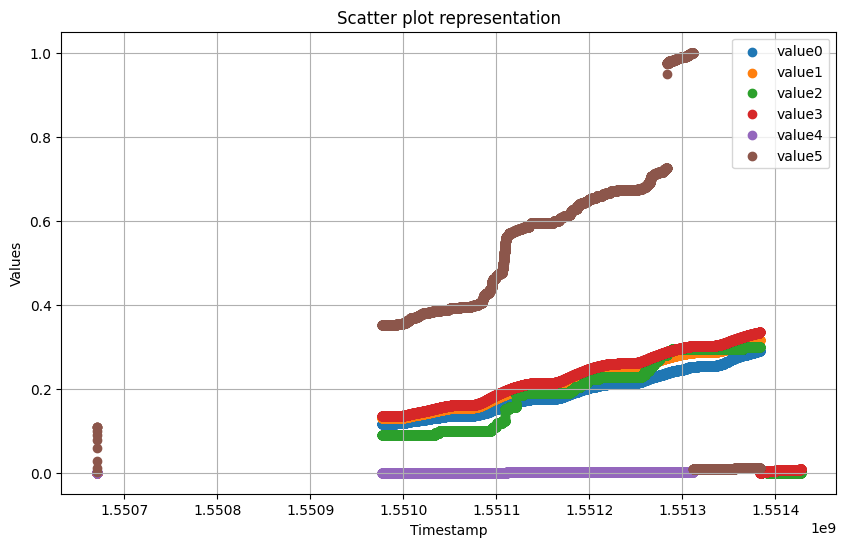

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot for each feature
plt.figure(figsize=(10, 6))  # Set the figure size as desired

for feature in df_4_slice.columns:
    plt.scatter(df_4_slice.index, df_4_slice[feature], label=feature)

plt.xlabel('Timestamp')  # Set the x-axis label as appropriate
plt.ylabel('Values')  # Set the y-axis label as appropriate
plt.title('Scatter plot representation')  # Set the plot title
plt.legend()  # Show the legend with feature names
plt.grid(True)  # Add gridlines to the plot
plt.show()  # Show the scatter plot

<ipython-input-21-90fad99ca5e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_slice.fillna(df_4_slice.mean(), inplace=True) ## fill the NaN value with the mean so OC-SVM can be trained


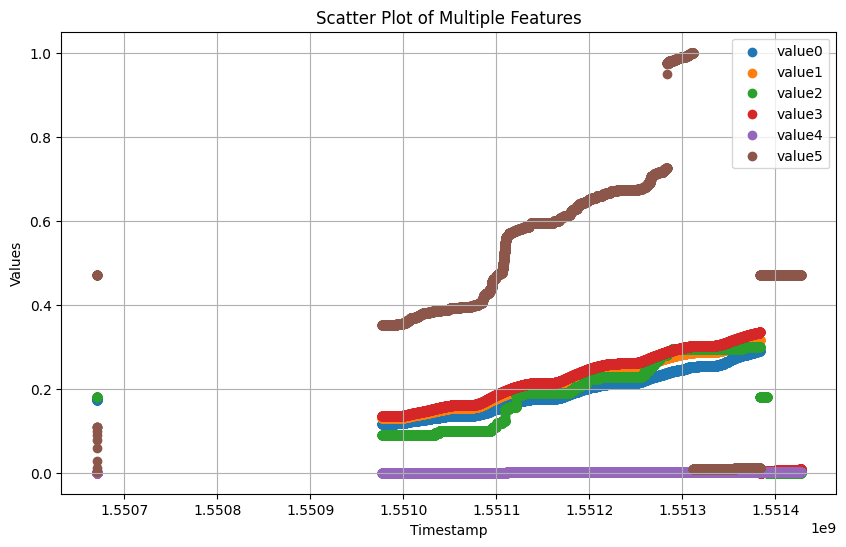

In [ ]:
df_4_slice.fillna(df_4_slice.mean(), inplace=True) ## fill the NaN value with the mean so OC-SVM can be trained
import matplotlib.pyplot as plt

# Create a scatter plot for each feature
plt.figure(figsize=(10, 6))  # Set the figure size as desired

for feature in df_4_slice.columns:
    plt.scatter(df_4_slice.index, df_4_slice[feature], label=feature)

plt.xlabel('Timestamp')  # Set the x-axis label as appropriate
plt.ylabel('Values')  # Set the y-axis label as appropriate
plt.title('Scatter Plot of Multiple Features')  # Set the plot title
plt.legend()  # Show the legend with feature names
plt.grid(True)  # Add gridlines to the plot
plt.show()  # Show the scatter plot

nu: 0.001, kernel: linear


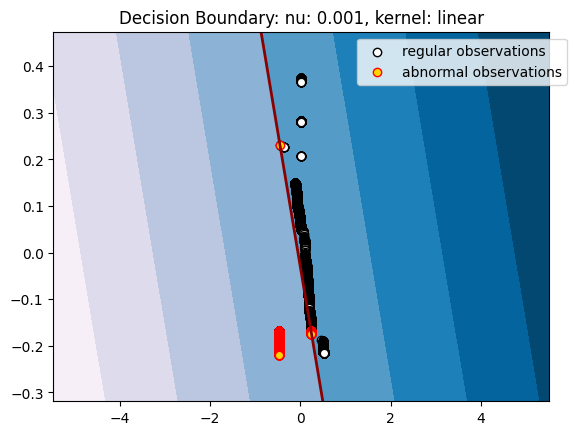

nu: 0.03, kernel: linear


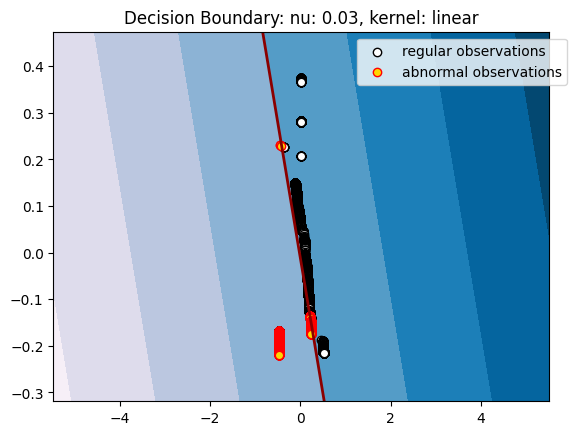

nu: 0.1, kernel: linear


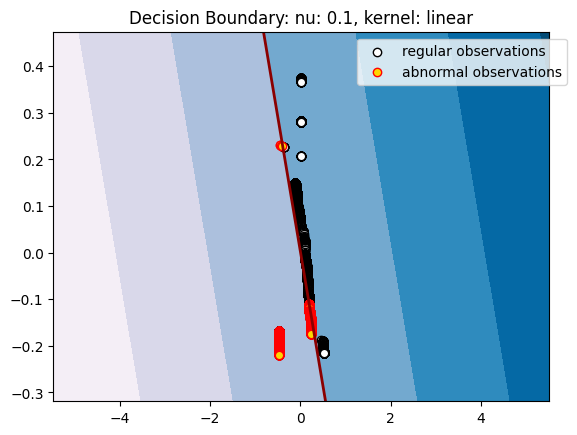

nu: 0.3, kernel: linear


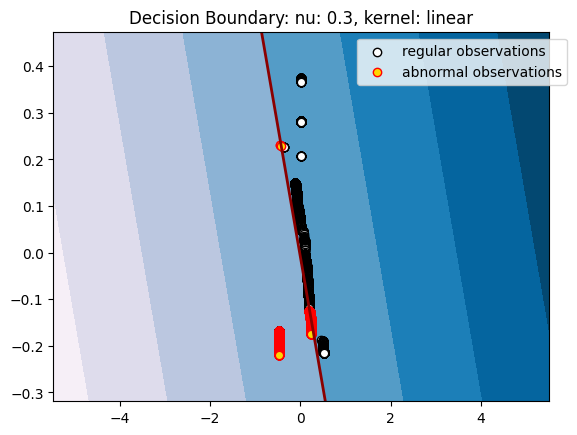

nu: 0.5, kernel: linear


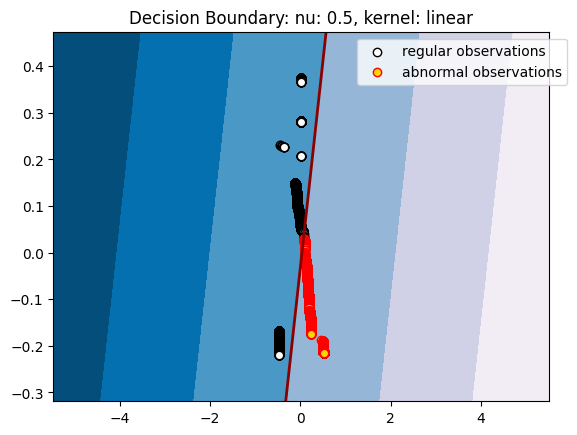

nu: 0.9, kernel: linear


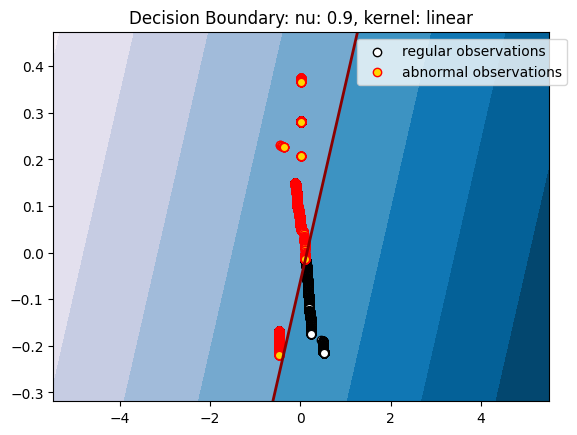

nu: 0.99, kernel: linear


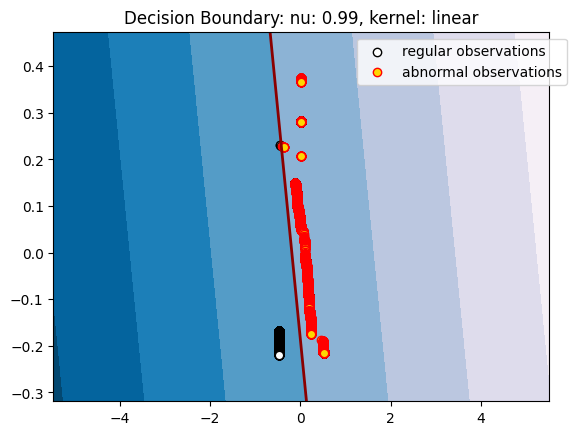

nu: 0.001, kernel: poly


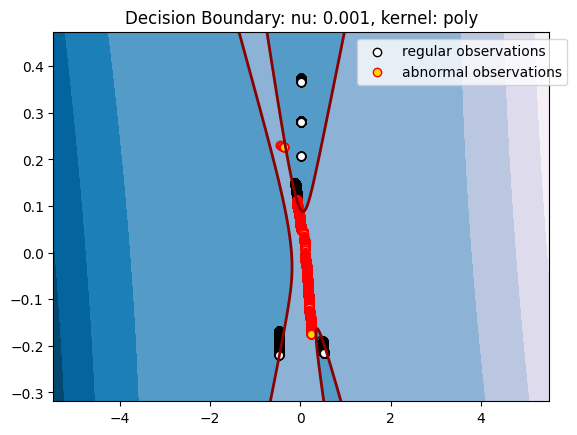

nu: 0.03, kernel: poly


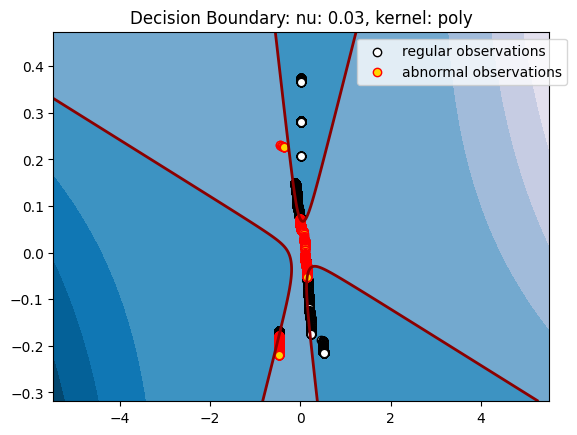

nu: 0.1, kernel: poly


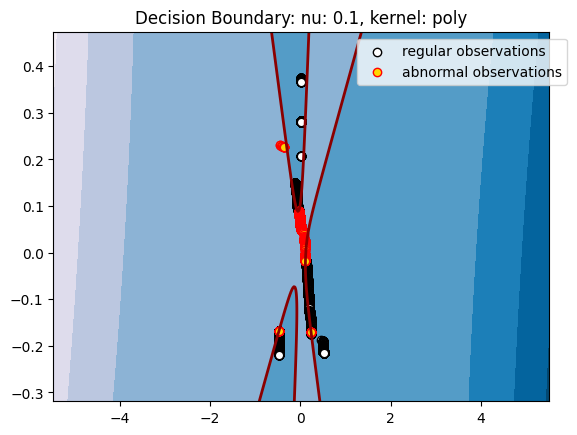

nu: 0.3, kernel: poly


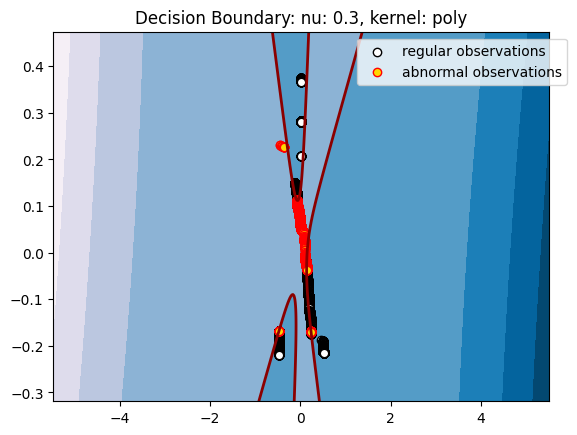

nu: 0.5, kernel: poly


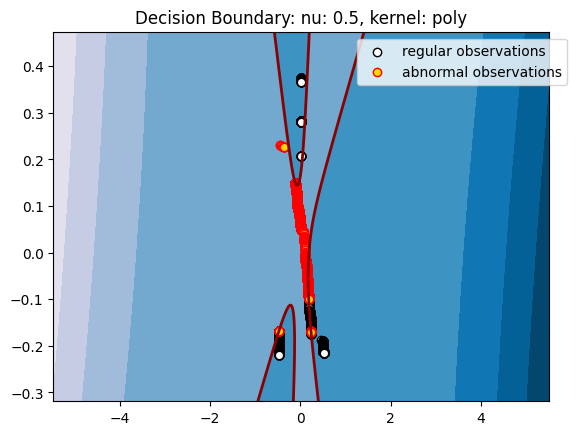

nu: 0.9, kernel: poly


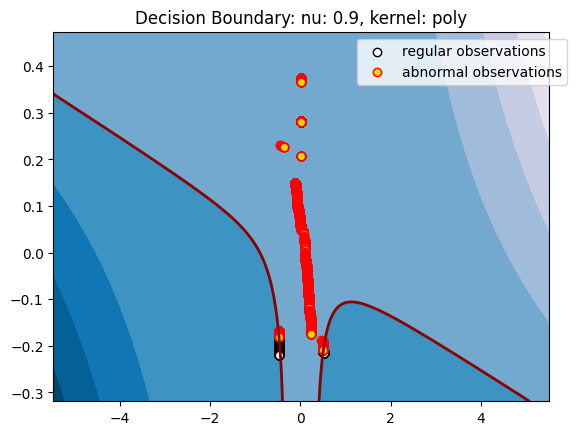

nu: 0.99, kernel: poly


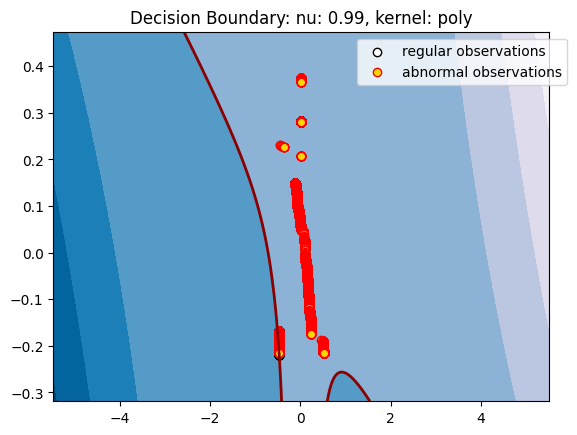

nu: 0.001, kernel: rbf


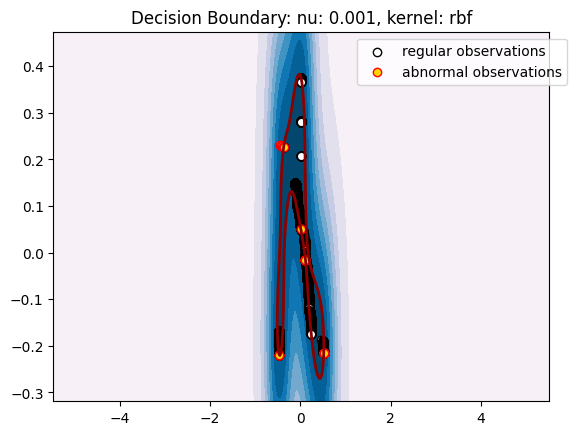

nu: 0.03, kernel: rbf


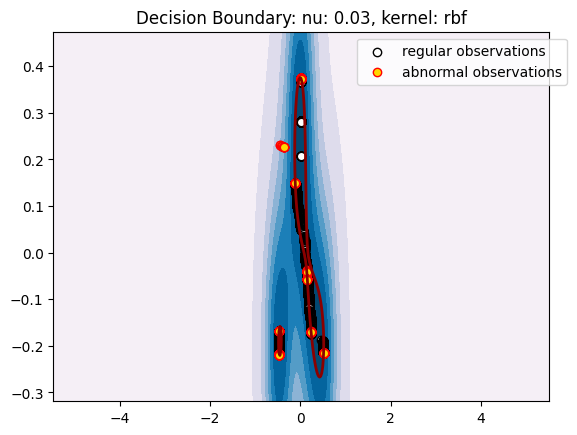

nu: 0.1, kernel: rbf


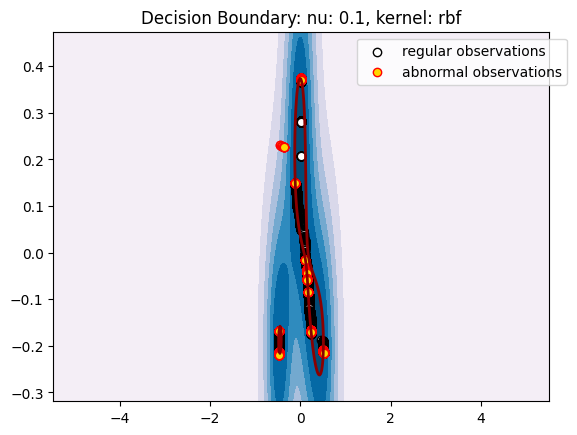

nu: 0.3, kernel: rbf


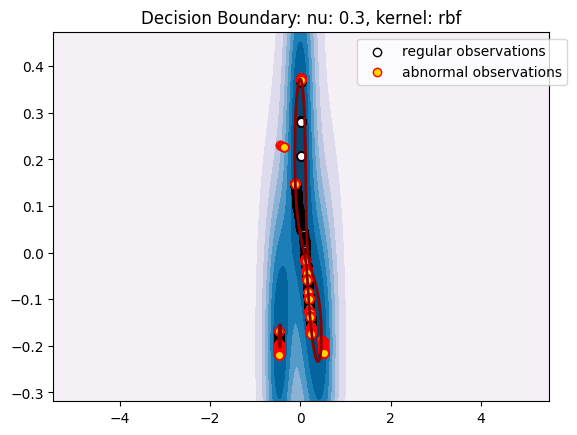

nu: 0.5, kernel: rbf


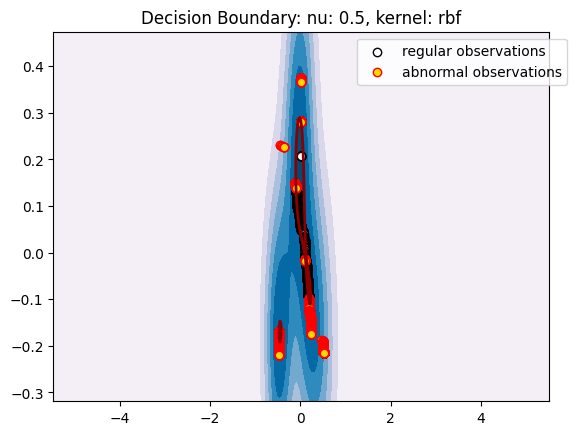

nu: 0.9, kernel: rbf


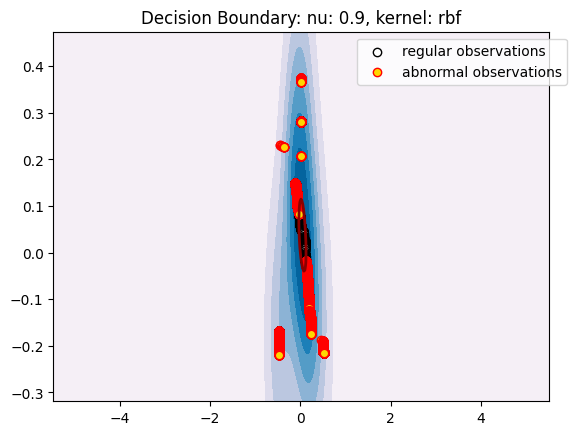

nu: 0.99, kernel: rbf


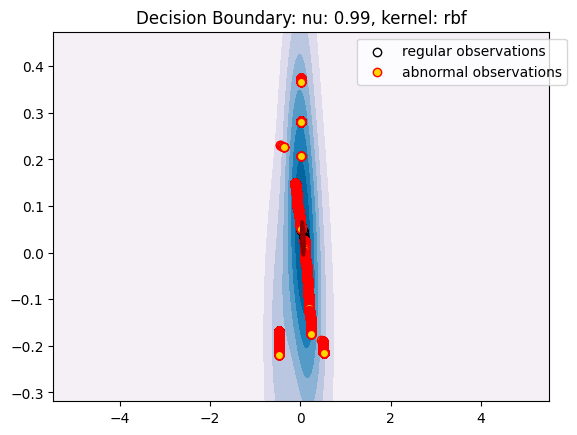

nu: 0.001, kernel: sigmoid


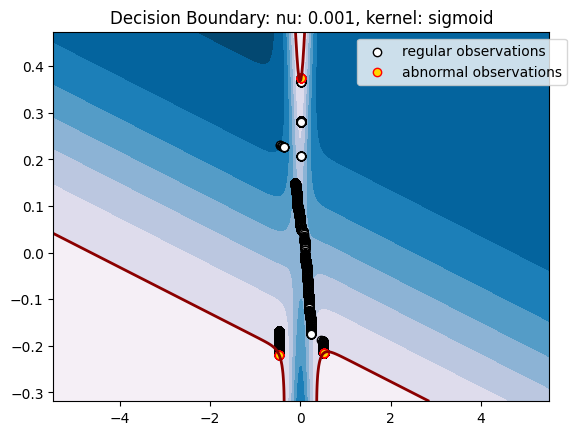

nu: 0.03, kernel: sigmoid


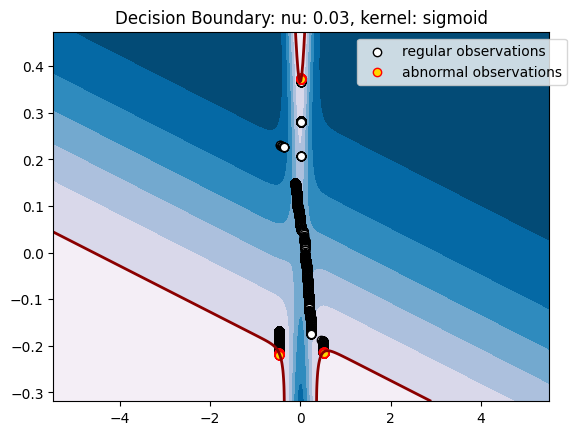

nu: 0.1, kernel: sigmoid


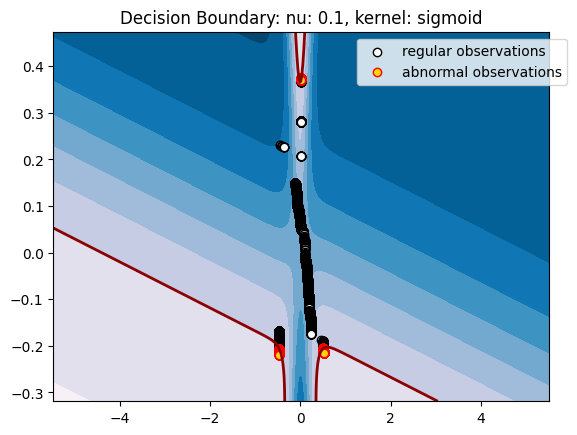

nu: 0.3, kernel: sigmoid


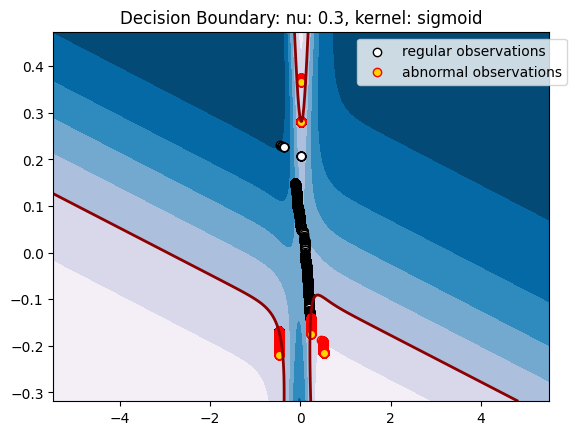

nu: 0.5, kernel: sigmoid


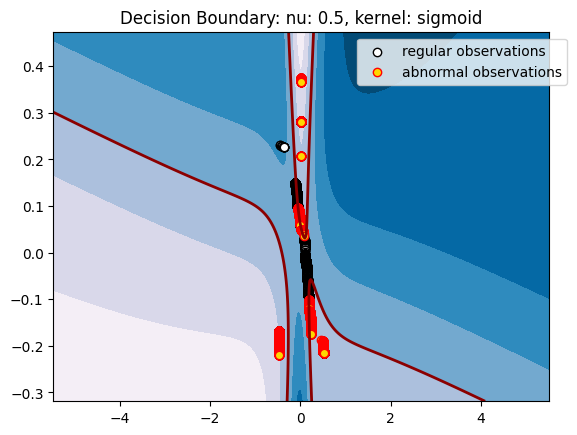

nu: 0.9, kernel: sigmoid


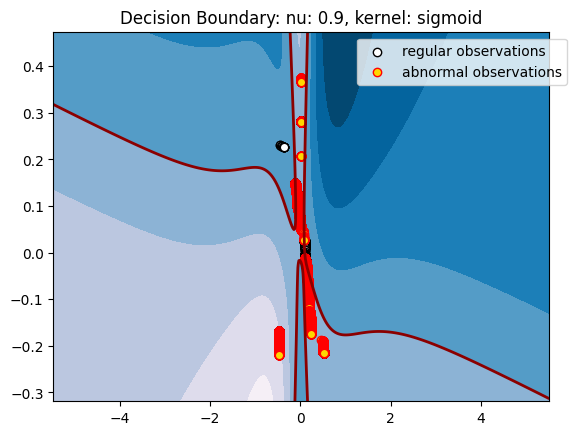

nu: 0.99, kernel: sigmoid


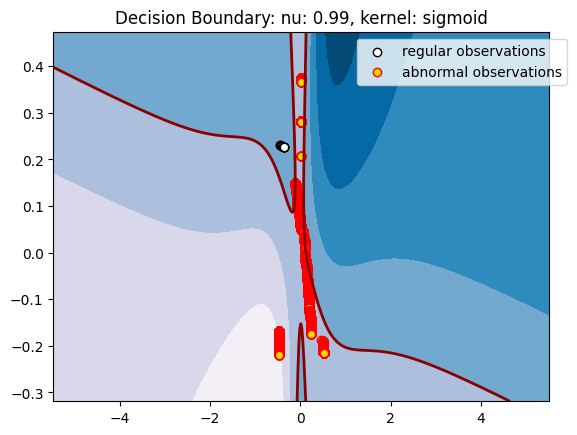

In [ ]:
params = {'nu': [0.001, 0.03, 0.1, 0.3, 0.5, 0.9, 0.99],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} # precomputed is not present because it needs a square matrix

train_multiple_ocsvm_with_pca(df_4_slice, params)

**Conclusioni 18/07/23**

Il training su più feature ha portato risultati molto più interessanti e decision boundaries più complessi, mostrando chiaramente la differenza tra i vari kernel, cosa che non accadeva con un dataset di circa le stesse dimensioni con una sola feature. Non penso, però, che questi risultati possano esser considerati una soluzione molto corretta al problema, risultato che, d'altronde, non mi coglie alla sprovvista.

# plot altri file
In questo blocco provo a plottare altri file per osservare se anche essi contengono valori nulli

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
file_type = 'compat_http_responses_2021-07-17T00-00-00'
df_check = load_time_series(path=path, features=[x for x in range(6)], file_type=file_type, max_files=2, intersection=False)

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2021-07-17T00-00-00.json



<Axes: xlabel='timestamp'>

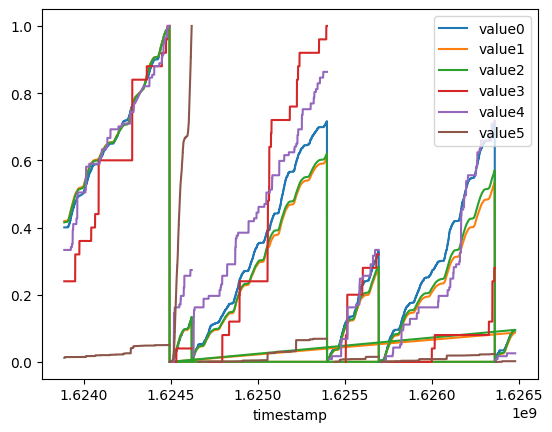

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_check_normalized = pd.DataFrame(scaler.fit_transform(df_check), index=df_check.index, columns=df_check.columns)
df_check_normalized.plot()

In [ ]:

path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
file_type = 'compat_http_responses_2020-08-21T00-00-00'
df_check = load_time_series(path=path, features=[x for x in range(6)], file_type=file_type, max_files=2, intersection=False)

Reading file ./drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/compat_http_responses_2020-08-21T00-00-00.json



<Axes: xlabel='timestamp'>

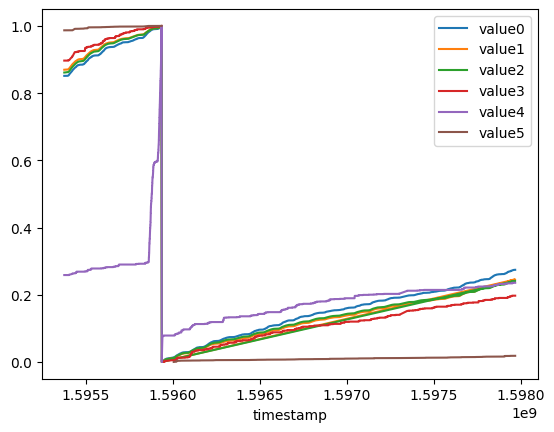

In [ ]:
scaler = MinMaxScaler()
df_check_normalized = pd.DataFrame(scaler.fit_transform(df_check), index=df_check.index, columns=df_check.columns)
df_check_normalized.plot()

Plot grosso dataset singola feature

In [ ]:
path = './drive/MyDrive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/'
file_type = 'compat_http_responses_2021-07-17T00-00-00'
df_check = load_time_series(path=path, features=[0], file_type=file_type, max_files=20, intersection=False)